### Exploring ECG signals

- work with wfdb to visualize ecg signals and detect QRS complexes
- generate spectograms, scalograms
- encoding time series for deep learning
- build noisy signals
- build train/test set

Imports... If you are missing them, use
-  %pip install library1 library2 .. 

In [4]:
import torch
import torchaudio 
import wfdb
import os
import sys
import wfdb
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import stft
from wfdb import processing

print('Virtual Environment:')
print(sys.prefix)


Virtual Environment:
c:\Users\Pie\Desktop\Thesis\code\signal-denoising\.venv


#### Load ECG signals with WFDB and detect QRS complexes

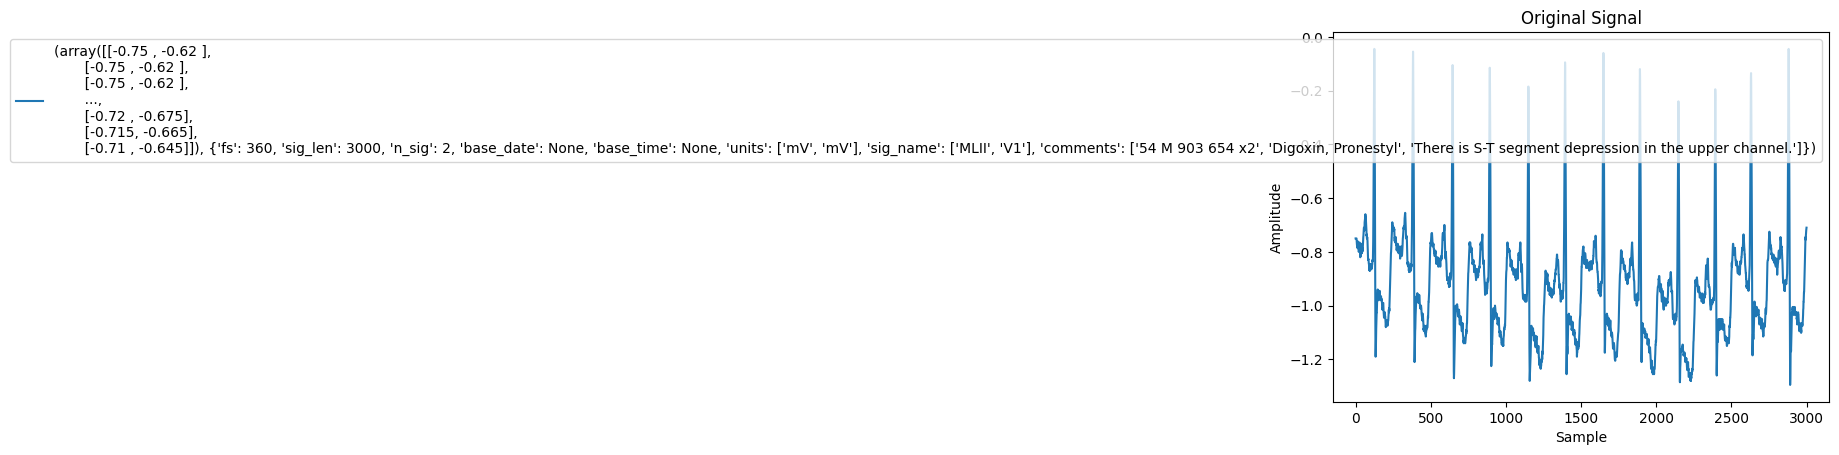

In [3]:
# Path to individual ecg file
# path_102 = "data/nstdb/118e06"
path_102 = "data/ardb/112"

# Extract record
record_102 = wfdb.rdsamp(path_102, sampto=3000)

# Extract Lead I ECG signal
signal_102 = record_102[0][:, 0]

plt.plot(signal_102, label=str(record_102))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Original Signal')
plt.legend()
plt.show()

We proceed to extract the QRS complexes, we can use this to create windows to later build the spectograms.

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


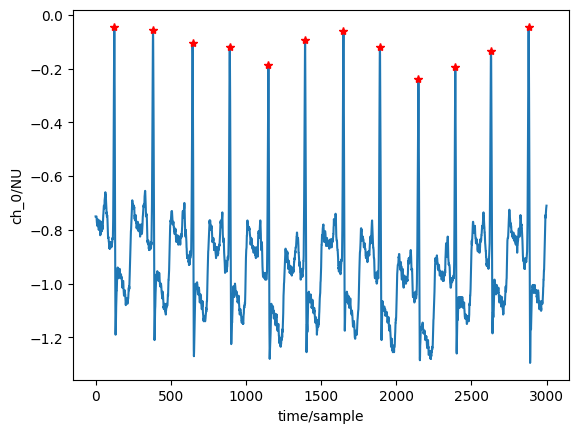

[ 124  382  645  893 1149 1393 1648 1891 2147 2392 2630 2880]


In [5]:
import wfdb
from wfdb import processing

# Load the ECG signal
path_102 = "data/ardb/112"
sig, fields = wfdb.rdsamp(path_102, channels=[0])

# Extract the first 3000 samples of the signal
sig = sig[:3000]

# Initialize the XQRS detector
xqrs = processing.XQRS(sig=sig[:, 0], fs=fields['fs'])

# Detect QRS complexes
xqrs.detect()

# Plot the signal with QRS complex annotations
wfdb.plot_items(signal=sig, ann_samp=[xqrs.qrs_inds])

print(xqrs.qrs_inds)


We can visualize noise signals.. or extract individual heartbeats.

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


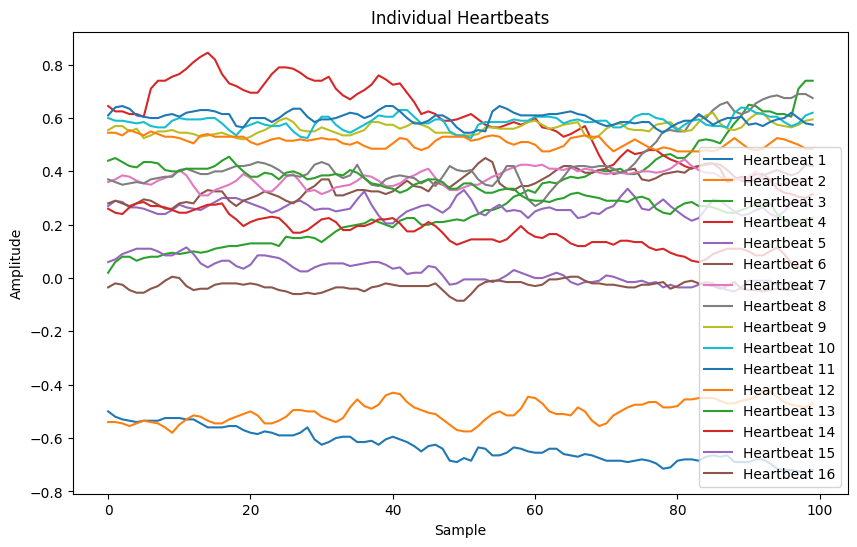

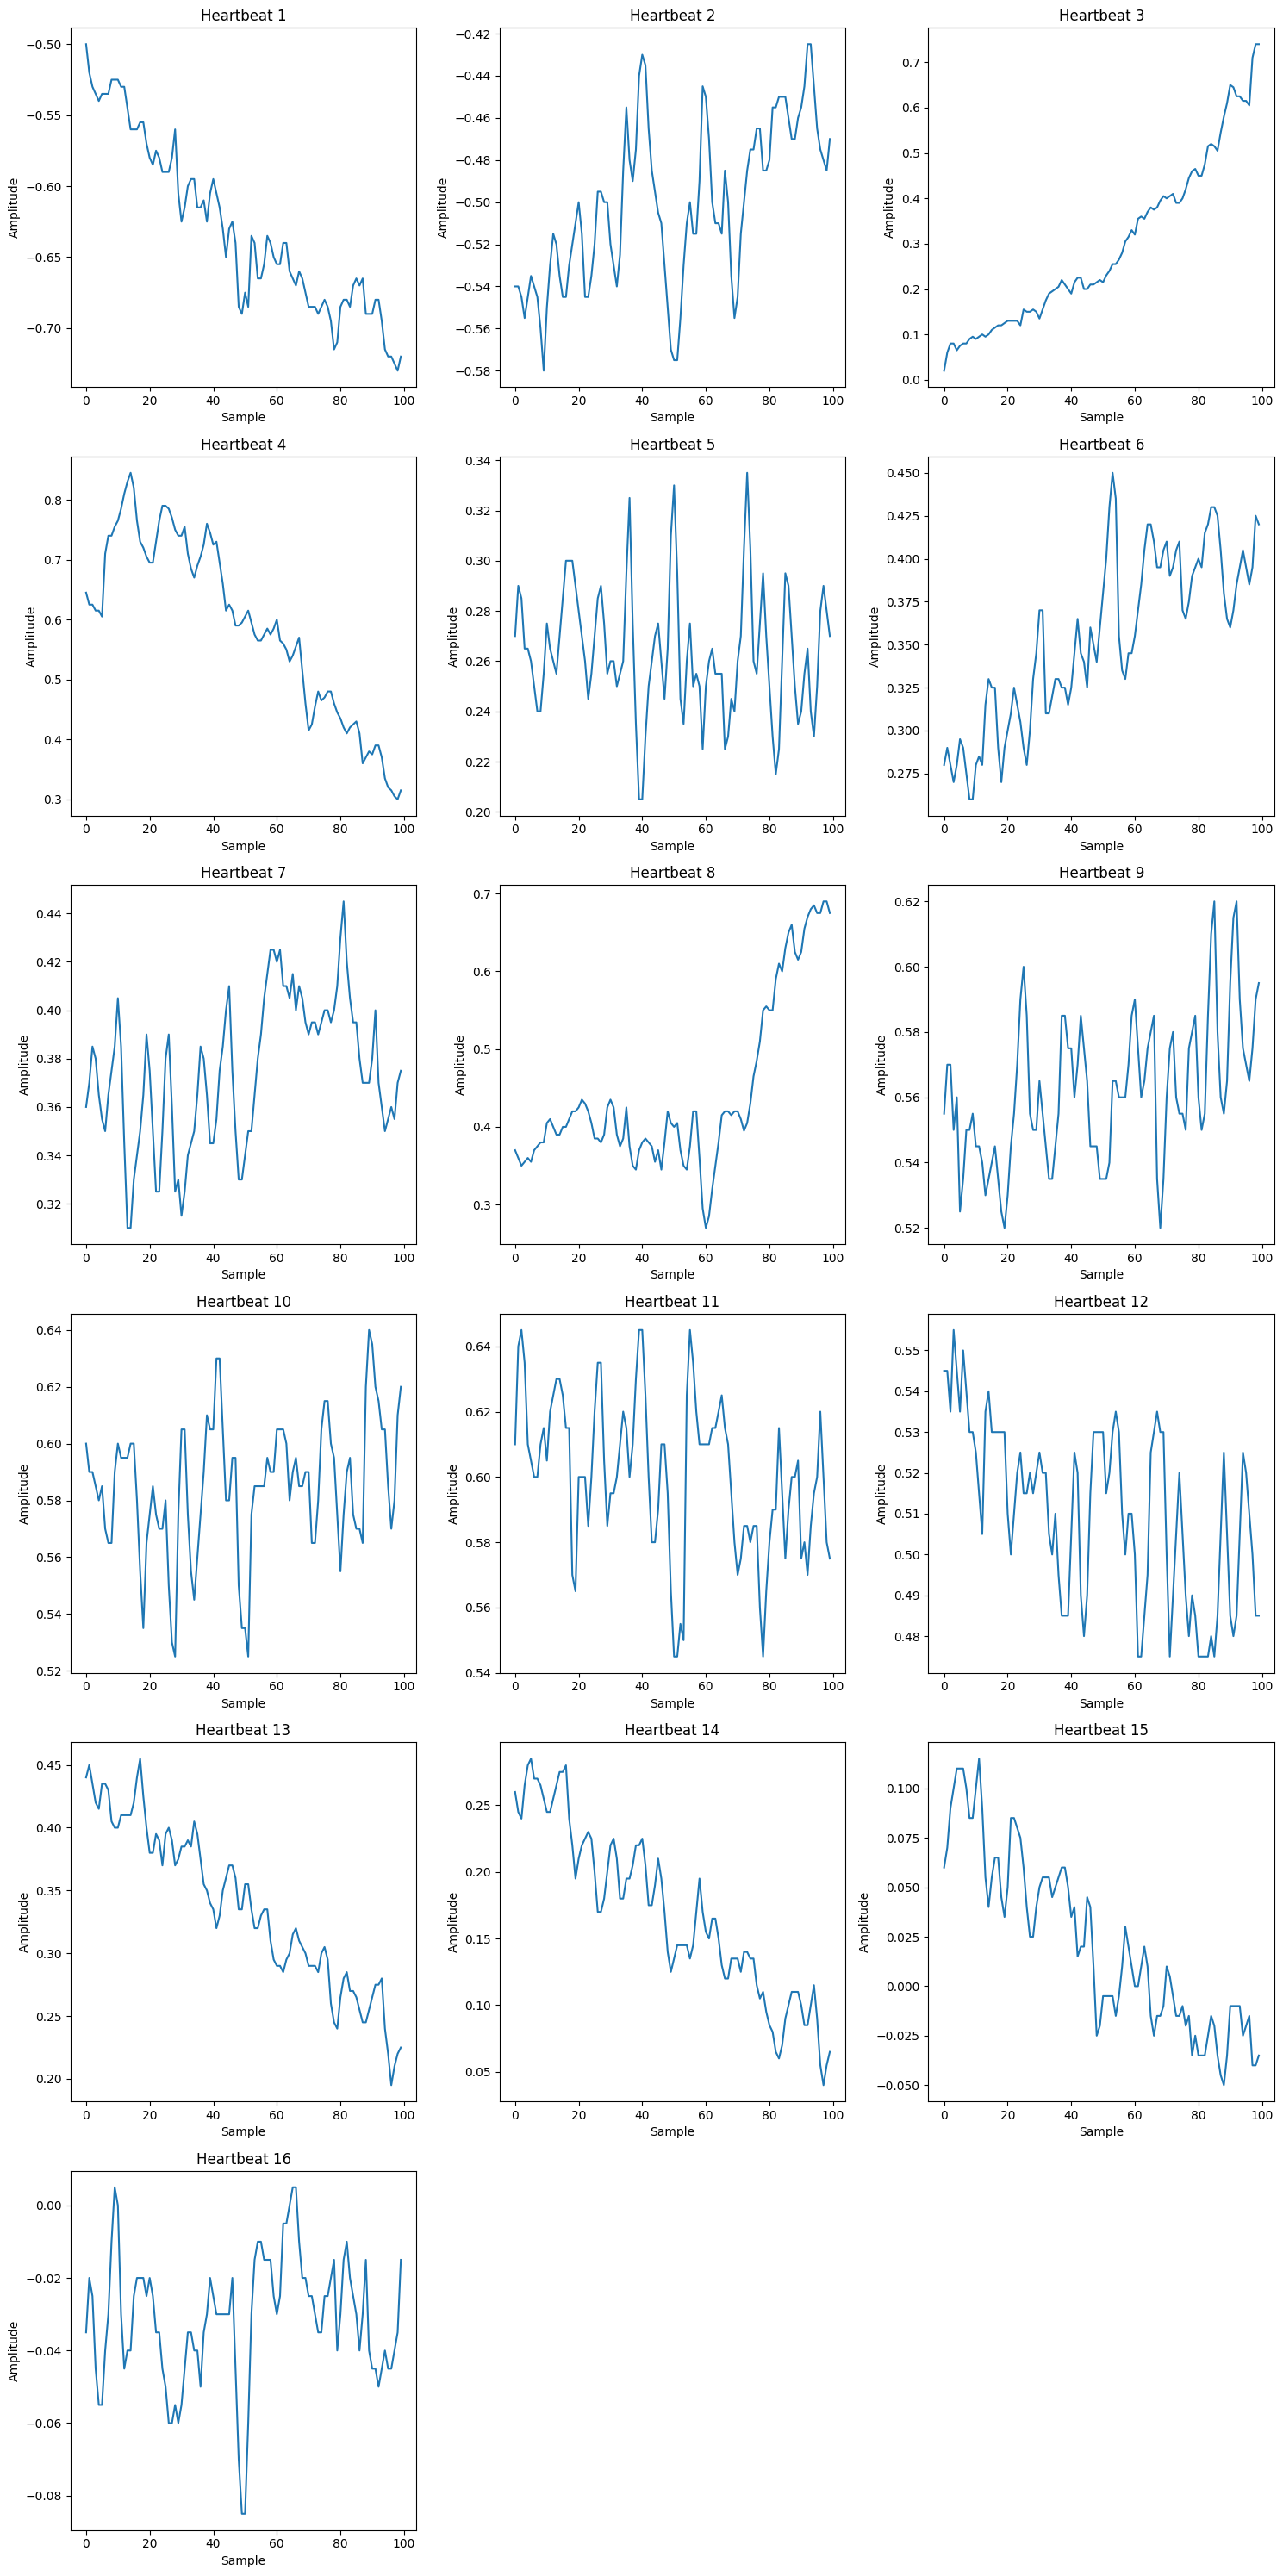

Duration: 8.33 seconds
Average duration of a heartbeat: 0.48 seconds


In [6]:
# Load the ECG signal
# path_102 = "data/ardb/112"
path_102 = "data/nstdb/bw"
sig, fields = wfdb.rdsamp(path_102, channels=[0])

# Extract the first 3000 samples of the signal
sig = sig[:3000]

# Initialize the XQRS detector
xqrs = processing.XQRS(sig=sig[:, 0], fs=fields['fs'])

# Detect QRS complexes
xqrs.detect()

# Segment the signal around QRS complexes
window_size = 100  # Define the window size around each QRS complex
heartbeats = []
for qrs_index in xqrs.qrs_inds:
    start_index = max(0, qrs_index - window_size // 2)
    end_index = min(len(sig), qrs_index + window_size // 2)
    heartbeat = sig[start_index:end_index]
    heartbeats.append(heartbeat)

sig = heartbeats[1]

# Plot the individual heartbeats
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, heartbeat in enumerate(heartbeats):
    plt.plot(heartbeat, label=f"Heartbeat {i+1}")

plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Individual Heartbeats')
plt.legend()
plt.show()

# Plot the individual heartbeats in separate subplots
num_beats = len(heartbeats)
num_cols = 3  # Define the number of columns for subplots
num_rows = (num_beats + num_cols - 1) // num_cols  # Calculate the number of rows

plt.figure(figsize=(15, 5*num_rows))
for i, heartbeat in enumerate(heartbeats):
    plt.subplot(num_rows, num_cols, i+1)
    plt.plot(heartbeat)
    plt.title(f"Heartbeat {i+1}")
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Duration
sampling_frequency = 360
num_samples = 3000
duration = num_samples / sampling_frequency

print(f"Duration: {duration:.2f} seconds")

# Calculate the intervals between consecutive QRS complexes
qrs_intervals = np.diff(xqrs.qrs_inds) / fields['fs']  # Convert samples to seconds

# Calculate the average duration of a heartbeat
avg_heartbeat_duration = np.mean(qrs_intervals)

print(f"Average duration of a heartbeat: {avg_heartbeat_duration:.2f} seconds")

#### Generate Spectograms and Scalograms

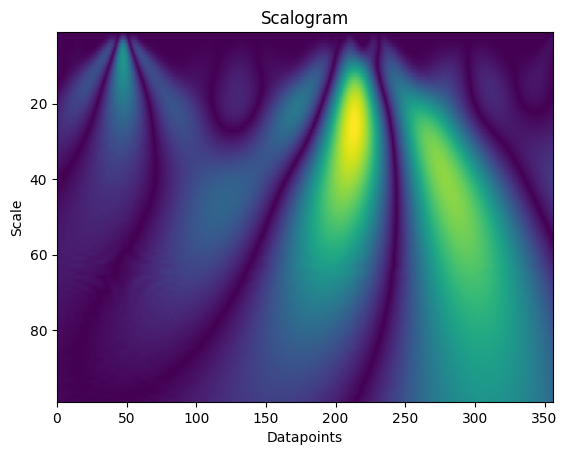

In [103]:
# Load record
record = wfdb.rdsamp('data/ardb/208', sampto=356)
I = record[0][:, 0]             # extract first 

# # Perform Short-Time Fourier Transform (STFT) on Lead I ECG signal
# f, t, Zxx = stft(I, fs=360)

# # Plot STFT
# plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('STFT of Lead I ECG signal')
# plt.colorbar(label='Magnitude')
# plt.show()

scales = np.arange(1, 100)
cwt_result, _ = pywt.cwt(I, scales, 'mexh')

# # Plot scalogram
plt.imshow(np.abs(cwt_result), aspect='auto', extent=[0, len(I), scales[-1], scales[0]])
plt.ylabel('Scale')
plt.xlabel('Datapoints')
plt.title('Scalogram')
plt.show()

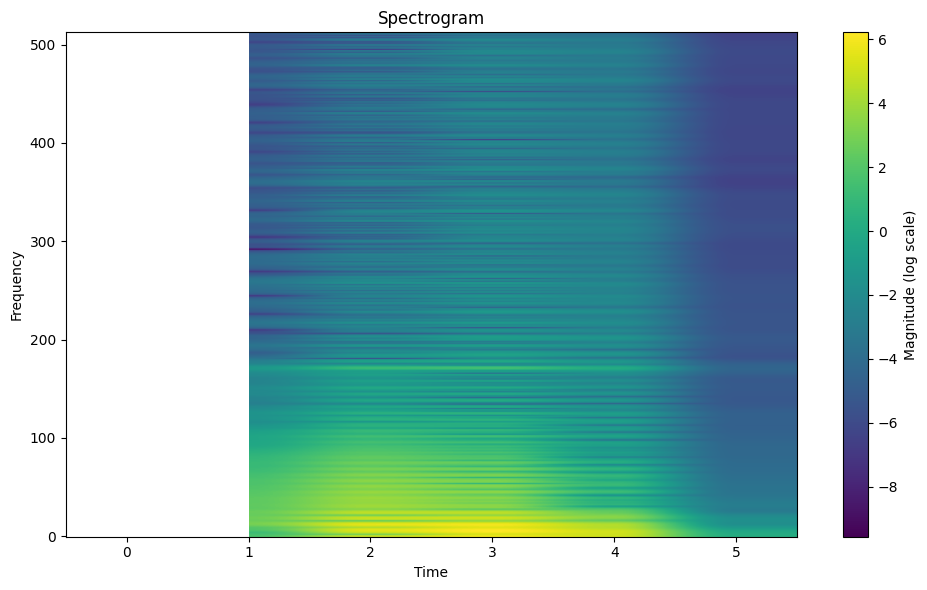

In [104]:
# Convert the NumPy array I to a PyTorch tensor
I_tensor = torch.tensor(I)

# Define the parameters for the STFT
n_fft = 1024  # Number of FFT bins
hop_length = 256  # Hop length for STFT
win_length = None  # Window size (defaults to n_fft)
window = torch.hann_window(n_fft, periodic=True)
center = True  # Whether to pad waveform on both sides
pad_mode = 'reflect'  # Padding method
normalized = False  # Whether to normalize the output
onesided = True  # Whether to return only half of the results (for real-valued signals)

# Compute the necessary padding size
pad_size = n_fft // 2

# Pad the input tensor
I_padded = torch.nn.functional.pad(I_tensor, (pad_size, pad_size), mode='constant')

# Compute the STFT
stft = torch.stft(I_padded, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center, pad_mode=pad_mode, normalized=normalized, onesided=onesided, return_complex=True)

# Compute the magnitude spectrogram
magnitude = torch.abs(stft)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(magnitude.log2().numpy(), aspect='auto', origin='lower')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Magnitude (log scale)')
plt.tight_layout()
plt.show()


#### Encoding Timeseries for Deep Learning
We can use an alternative approach from this paper (https://arxiv.org/pdf/1506.00327.pdf) also used in a paper that used diffusion models to generate ECG signals (https://arxiv.org/pdf/2303.02475.pdf).

Further researched in this paper (https://www.researchgate.net/figure/Conceptual-block-diagram-of-the-proposed-structure-for-individual-household-power_fig4_338359485)

Not investigated: 
- recurrence plots

min -1.0
max 1.0


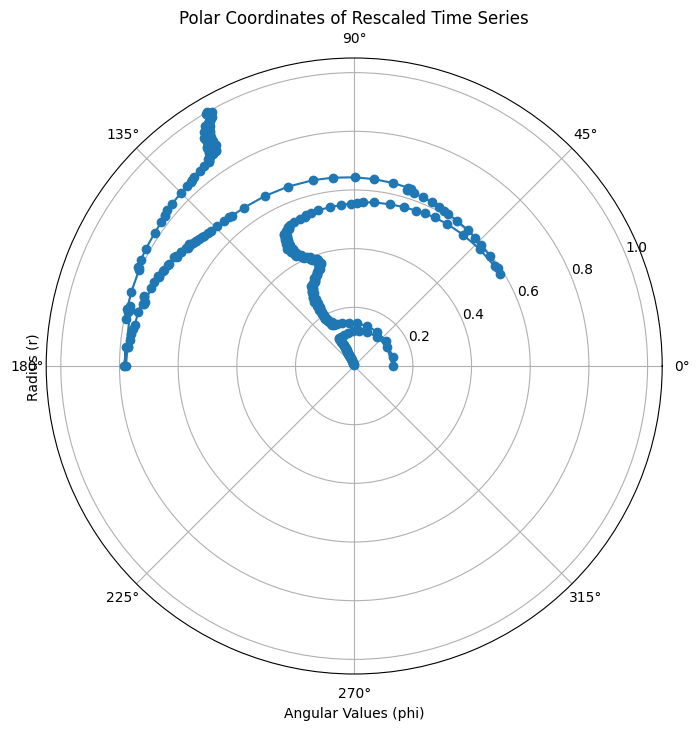

In [105]:
# taken from paper 'Generating ECG using Diffusion Models'
def rescale_time_series(X):     
    """
    Rescale the time series X to fall within the interval [-1, 1].
    
    Parameters:
    X (array-like): The input time series.
    
    Returns:
    X_rescaled (array-like): The rescaled time series.
    """
    X_min = np.min(X)
    X_max = np.max(X)
    X_rescaled = (X - X_max + (X - X_min)) / (X_max - X_min)
    return X_rescaled

X=I
X = rescale_time_series(X)
print('min',  np.min(X))
print('max',  np.max(X))

# Calculate the radius values 'r' using the time stamps
r = np.arange(1, len(X) + 1) / len(X)

# Calculate the angular values 'phi' using the rescaled time series
phi = np.arccos(X)

# Plot the polar coordinates
plt.figure(figsize=(8, 8))
plt.polar(phi, r, marker='o', linestyle='-')
plt.title('Polar Coordinates of Rescaled Time Series')
plt.xlabel('Angular Values (phi)')
plt.ylabel('Radius (r)')
plt.grid(True)
plt.show()

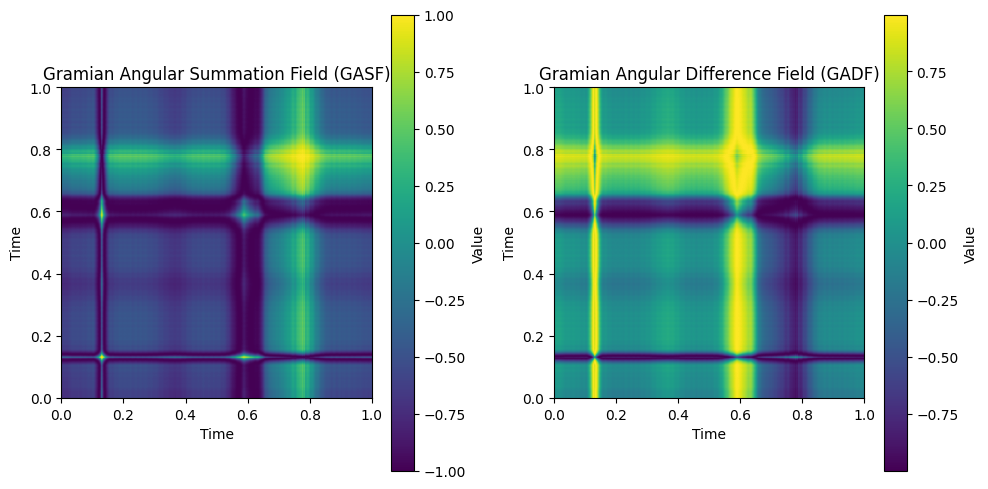

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField


# Right format to use GramianAngularField
X = np.array([I])

# Compute Gramian angular fields
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(X)

gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform(X)

# Plot the GASF
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_gasf[0], origin='lower', extent=[0, len(X), 0, len(X)])
plt.title('Gramian Angular Summation Field (GASF)')
plt.xlabel('Time')
plt.ylabel('Time')
plt.colorbar(label='Value')

# Plot the GADF
plt.subplot(1, 2, 2)
plt.imshow(X_gadf[0], origin='lower', extent=[0, len(X), 0, len(X)])
plt.title('Gramian Angular Difference Field (GADF)')
plt.xlabel('Time')
plt.ylabel('Time')
plt.colorbar(label='Value')

plt.tight_layout()
plt.show()


(1, 356, 356)


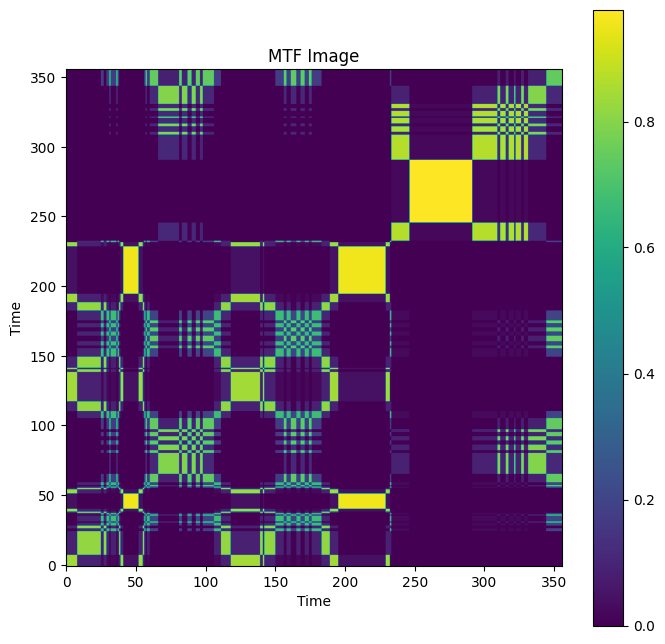

In [107]:
from pyts.image import MarkovTransitionField

transformer = MarkovTransitionField()
X_new = transformer.transform(X)
X_new.shape

print(X_new.shape)

X_mtf = X_new

# Visualize MTF
plt.figure(figsize=(8, 8))
plt.imshow(X_new[0], origin='lower')
plt.title('MTF Image')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()

In [130]:
# Combine the techniques to convert 1D ECG into 2D Embedding (image)
#   - INPUT=1D time series (one lead)
#   - OUTPUT=2D embedding of summated GASF, GADF, MTF
def embed_ECG(X):       # TODO: make this method faster...
    # rescale 
    X = rescale_time_series(X)
    # numpy
    X = np.array([X])

    # Compute Gramian angular fields
    gasf = GramianAngularField(method='summation')
    X_gasf = gasf.fit_transform(X)

    gadf = GramianAngularField(method='difference')
    X_gadf = gadf.fit_transform(X)

    # Copmute Markov Transition Field
    transformer = MarkovTransitionField()
    X_mtf = transformer.transform(X)    

    # Combine the three matrices, as done in paper on ECG synthesis
    # return X_gasf[0] + X_gadf[0] + X_mtf[0]
    return X_gasf[0]


# Helper method to visualize
def visualize_ecg_2D(ecg_2D):
    plt.figure(figsize=(8, 6))
    plt.imshow(ecg_2D)
    plt.title('2D Representation of ECG Signal')
    plt.xlabel('Time')
    plt.ylabel('Channels')
    plt.colorbar(label='Magnitude')
    plt.show()

def de_embedd(X_2D):
    # Extract the cosine values from the GASF channel
    X_cosine = np.cos(X_2D)

    # Map the cosine values to angles using arccos
    X_phi = np.arccos(X_cosine)

    # Extract only the elements along the main diagonal
    X_phi_diagonal = np.diag(X_phi)

    return X_phi_diagonal

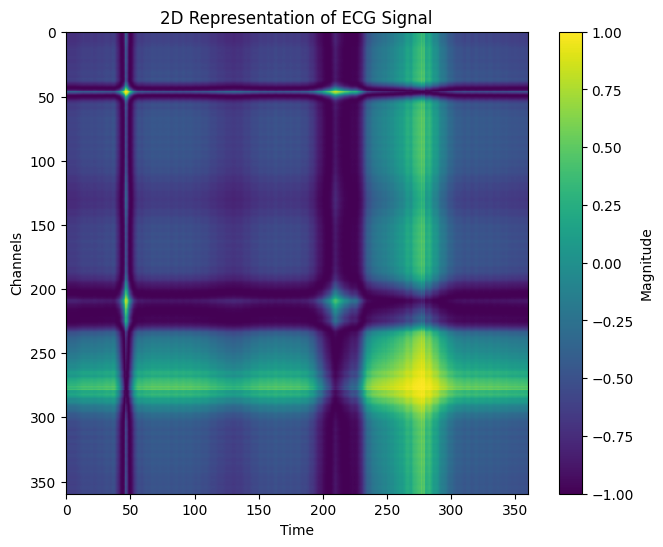

[0.72408163 0.72408163 0.72408163 0.72408163 0.72408163 0.72408163
 0.72408163 0.72408163 0.70374409 0.68268343 0.67730528 0.6497366
 0.62686816 0.61516277 0.62103806 0.62103806 0.62686816 0.62103806
 0.62103806 0.60924229 0.60924229 0.63265306 0.63265306 0.62103806
 0.6032766  0.59120966 0.59120966 0.60924229 0.60924229 0.5851084
 0.56653344 0.54755173 0.55392416 0.56653344 0.5851084  0.56653344
 0.52161006 0.55392416 0.66089965 0.80665207 0.92528776 0.99524892
 0.9647426  0.73886025 0.23078314 0.47515571 1.         0.8938832
 0.25325048 0.37355272 0.80244898 0.9905035  0.96822258 0.85356401
 0.71906504 0.60924229 0.55392416 0.54755173 0.57896194 0.57896194
 0.53467128 0.50836805 0.48816609 0.50167926 0.50167926 0.49494527
 0.45359226 0.44654191 0.46059742 0.46059742 0.47447214 0.46755738
 0.45359226 0.45359226 0.46059742 0.47447214 0.46755738 0.46059742
 0.46059742 0.43944637 0.46059742 0.49494527 0.49494527 0.47447214
 0.46755738 0.44654191 0.45359226 0.48816609 0.49494527 0.4813417

In [131]:
# Example
record = wfdb.rdsamp('data/ardb/208', sampto=360)
print()
ecg_2D = embed_ECG(record[0][:, 0])
visualize_ecg_2D(ecg_2D)

x = de_embedd(ecg_2D)
print(x)
print(x.shape)

print('******')

rescale_time_series
print(rescale_time_series(record[0][:, 0]))
print()


#### Build noisy samples


In [108]:
# 

**Build Training and validation set**: \
Now we will build a larger training set. At this point only from MIT-BIH Arrythmia, similar to (https://arxiv.org/pdf/2306.01875.pdf) - however we can later include a lot more data... and then we can potentially start using larger window, cause we have more data!

Let us do the following: 
- step 1 : generate synthetic heartbeats using latent flow matching 
- step 2 : adapt this strategy to denoise ECG signals : use supervised IR DM